In [1]:
# Packages
import pandas as pd
import math 
import numpy as np 
import seaborn as sns 
import os
import datetime as dt 
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import TwoSlopeNorm
import pickle
import matplotlib.cm as cm
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')

## Model 

### Summary 

- We model the utilities for SP's to terminate and reonboard sectors, or to extend sectors given the Introduction of a Linear [Sector Duration Multiplier](https://github.com/filecoin-project/FIPs/pull/571/files?short_path=bc7d545#diff-bc7d5451cff22ea4078a2039e141943566dc60be34316d5f7b920eb74dae8b97)

#### SP Utilities 

- We define SP Utilites $U_\text{T}$ and $U_\text{N}$ as an SP's utility to terminate or not terminate a sector respectively as 

$$ U_\text{T} = \frac{\sum_{t=t_{i}}^{t_{i}+D} E[R_\text{T}(t)] - G_\text{Reseal} - F_\text{T} - (IP_\text{Reseal} - IP_\text{initial}) - C_\text{Reseal}}{IP_\text{Reseal}} $$
and
$$ U_\text{N} = \frac{\sum_{t=t_i}^{t_i+D} E[R_\text{N}(t)]}{IP_\text{initial}} $$

in which 
- $t_i$ - date on which the SP looks to make the utility maximizing decision between terminating and resealing, or extending 
- $D$ - Projected Duration of Daily Rewards following the intervention_date
- $E[R_\text{T}(t)]$ - Expected Daily Reward on day $t$ for a sector that was terminated and then resealed with a duration miultiplier
- $E[R_\text{N}(t)]$ - Expected Daily Reward on day $t$ for a non-terminated or "extended" sector with a 1x quality multiplier 
- $G_\text{Reseal}$ - Gas Cost of Resealing a Sector
- $F_\text{T}$ - Fee paid for early termination of sector (assumed to be 90 Days of Expected Block Reward) 
- $IP_\text{Reseal}$ - Expected Initial Pledge when recommitting a sector following termination 
- $IP_\text{initial}$ - Collateral put up when the sector was initially committed 
- $C_\text{Reseal}$ - Machine Cost of computation to reseal a sector (note this is the only field that is denominated in fiat and then back in to FIL.

in which the Storage Provider is indifferent between terminating and reonboarding, or simply extending without the quality multiplier when: 

$$ U_\text{T} - U_\text{N} = 0 $$

### Termination Model - Investment and Data Conservation Regimes

In [17]:
durations_vec_yrs=[3,5]
lock_targets=[0.3]
burn_boosts=[1]
regimes = ['data_conserved', 'fil_conserved']
behaviors_vec = ['smooth', 'jump']
rbp_scan_vec=['last_historical']
rr_scan_vec=['last_historical']
filplus_scan_vec = [0.6]  # use mcmc or 100%, 80%, or 60%
duration_slopes_vec = [0.1, 0.285, 0.5, 1]

burn_boost = burn_boosts[0]
lock_target = lock_targets[0]
plt_regime = regimes[0]
duration_yr = durations_vec_yrs[0]
rbp_i = rbp_scan_vec[0]
rr_i = rr_scan_vec[0]
filplus_i = filplus_scan_vec[0]
duration_slope = duration_slopes_vec[1]


jump_key = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
    (burn_boost, lock_target, plt_regime, duration_yr, 'jump', str(rbp_i), 
     str(rr_i), str(filplus_i), duration_slope)
jump_key = 'SDM-(%s)' % (jump_key,)

smooth_key = 'bb=%d-lt=%0.02f-regime=%s-duration=%0.02f-behavior=%s-rbp=%s-rr=%s-fpr=%s-sdmslope=%0.02f' % \
    (burn_boost, lock_target, plt_regime, duration_yr, 'smooth', str(rbp_i), 
     str(rr_i), str(filplus_i), duration_slope)
smooth_key = 'SDM-(%s)' % (smooth_key,)

# The vectors show which configs were run, and the keys are how you access a specific config from the pkl file.

# Get Pickles 
path_conservation = os.getcwd() + '/results/incentive_to_terminate/'

# df where termination fee cap is 140 days 

with open(path_conservation + 'duration_loop_results_terminationfee140days.pkl', 'rb') as f:
    results_140 = pickle.load(f)

    
df_140_T = results_140[jump_key]
df_140_N = results_140[smooth_key]


Text(0, 0.5, 'ROI Ratio')

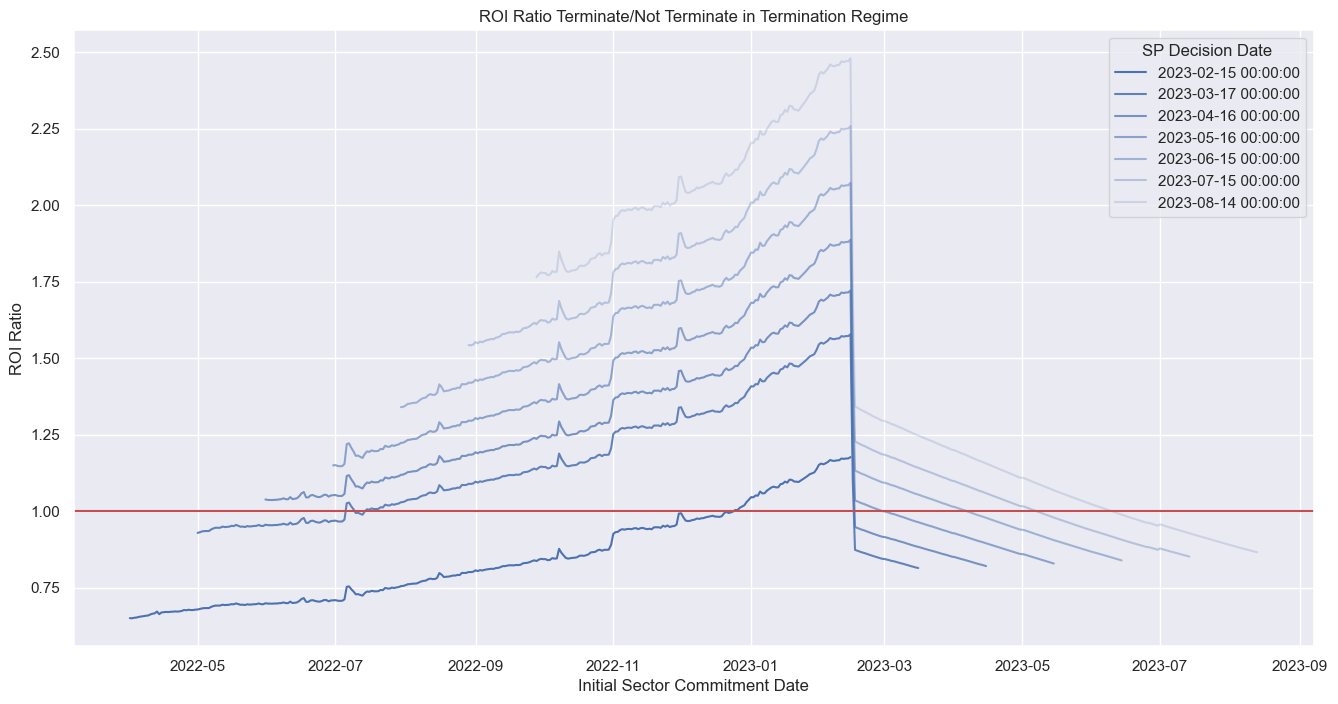

In [153]:
# compute ROI Ratios 

intervention_date = pd.to_datetime('2023-02-15')
decision_date = intervention_date
start_date = pd.to_datetime('2022-04-01')
reward_years = 1
end_date = decision_date + dt.timedelta(365 * reward_years)
seal_date = start_date
salvage_value = 1/3 * 0.2 

df = df_140_T['rbp_roi']
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

termination_mask = (df.index>=seal_date) & (df.index < decision_date)
rewards_mask = (df.index>=seal_date) & (df.index < end_date)
termination_cap = 5*140

ROI_ratios = {}

decision_dates = [intervention_date]
months = 6
for i in range(months): 
    decision_dates.append(decision_dates[-1] + dt.timedelta(30))

results_roi_ratios = {}

sdm_max = 2

for idx,decision_date in enumerate(decision_dates):
    
    seal_date = start_date + dt.timedelta(30*idx)
    roi_ratios_dict = {}
    end_date = decision_date + dt.timedelta(365 * reward_years)
    termination_mask = (df.index>=seal_date) & (df.index < decision_date)
    rewards_mask = (df.index>=seal_date) & (df.index < end_date)
    #results_mask = (df.index>=start_date) & (df.index<decision_date)
    
    while seal_date < decision_date: 
        
        ## Compare ROI Ratios for keeping 2 sectors vs salvage value for 1 and then resealing max power (maintain power)
        IP_seal = sdm_max * df[df.index==seal_date]['day_pledge_per_QAP'].values
        IP_reseal = sdm_max * df[df.index==decision_date]['day_pledge_per_QAP'].values

        ## Calc ROI Terminate
        
        block_reward_terminate = sdm_max * df[rewards_mask]['day_rewards_per_sector'].values.sum()
        termination_fee = df[termination_mask]['day_rewards_per_sector'].head(termination_cap).values.sum()
        ROI_terminate = ((block_reward_terminate) - (IP_reseal - IP_seal) - termination_fee + salvage_value)/IP_reseal

        ## Calc ROI No Temrinate    
        block_reward_no_terminate = sdm_max * df[rewards_mask]['day_rewards_per_sector'].values.sum()
        ROI_no_terminate = block_reward_no_terminate/IP_seal
        
        ratio = float(ROI_terminate/ROI_no_terminate)
        
        roi_ratios_dict[seal_date] = ratio
        
        seal_date += dt.timedelta(1)
    
    roi_ratios_df = pd.DataFrame.from_dict(roi_ratios_dict, orient='index')
    roi_ratios_df.rename(columns={0: str(decision_date)}, inplace=True)
    #roi_ratios_df.columns = decision_date
    results_roi_ratios[decision_date] = roi_ratios_df
    
sns.set(rc = {'figure.figsize':(16,8)})
alphas = np.linspace(1,0.2,len(results_roi_ratios.keys()))
for idx,decision_date in enumerate(results_roi_ratios.keys()):
    sns.lineplot(data=results_roi_ratios[decision_date], alpha=alphas[idx],
                 label=decision_date, legend=False)
plt.axhline(1, c='r')
plt.title('ROI Ratio Terminate/Not Terminate in Termination Regime')
plt.legend(title='SP Decision Date')
plt.xlabel('Initial Sector Commitment Date')
plt.ylabel('ROI Ratio')

Text(0, 0.5, 'ROI Ratio')

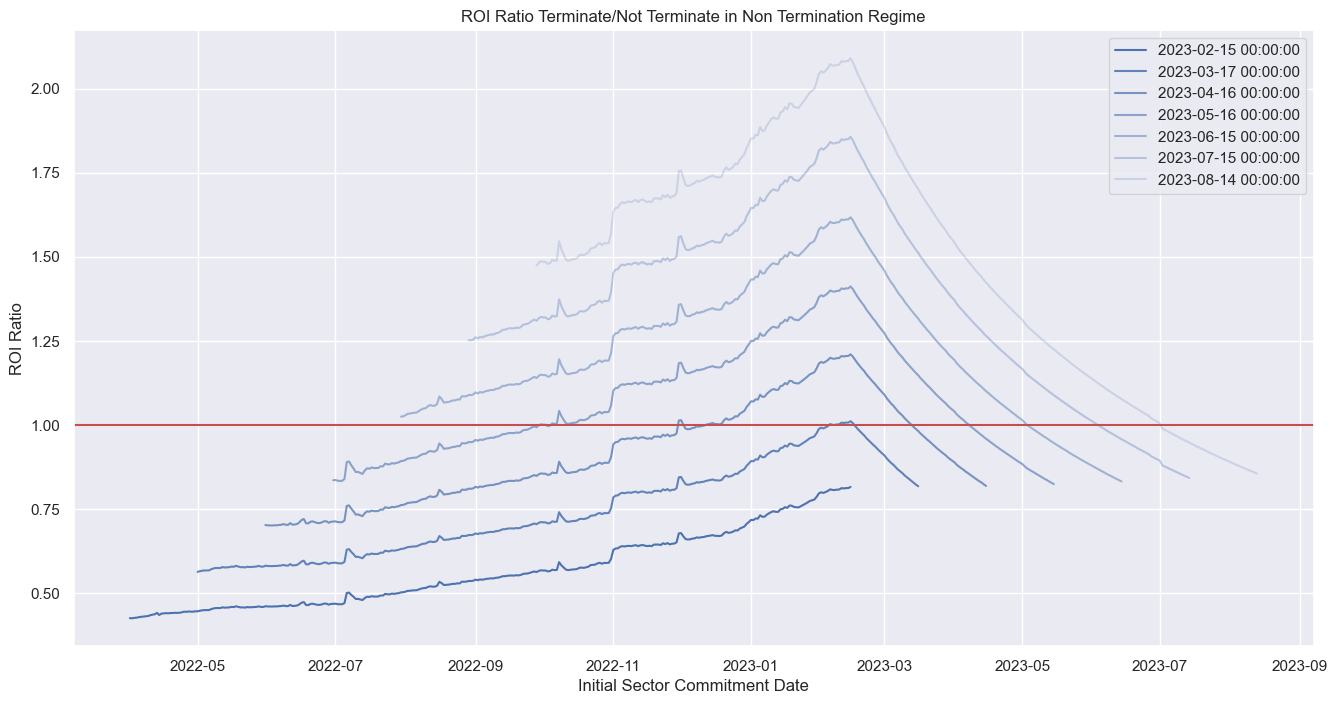

In [155]:
# compute ROI Ratios 

intervention_date = pd.to_datetime('2023-02-15')
decision_date = intervention_date
start_date = pd.to_datetime('2022-04-01')
reward_years = 1
end_date = decision_date + dt.timedelta(365 * reward_years)
seal_date = start_date
salvage_value = 1/3 * 0.2 

df = df_140_N['rbp_roi']
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

termination_mask = (df.index>=seal_date) & (df.index < decision_date)
rewards_mask = (df.index>=seal_date) & (df.index < end_date)
termination_cap = 5*140

ROI_ratios = {}

decision_dates = [intervention_date]
months = 6
for i in range(months): 
    decision_dates.append(decision_dates[-1] + dt.timedelta(30))

results_roi_ratios = {}

sdm_max = 2

for idx,decision_date in enumerate(decision_dates):
    
    seal_date = start_date + dt.timedelta(30*idx)
    roi_ratios_dict = {}
    end_date = decision_date + dt.timedelta(365 * reward_years)
    termination_mask = (df.index>=seal_date) & (df.index < decision_date)
    rewards_mask = (df.index>=seal_date) & (df.index < end_date)
    #results_mask = (df.index>=start_date) & (df.index<decision_date)
    
    while seal_date < decision_date: 
        
        ## Compare ROI Ratios for keeping 2 sectors vs salvage value for 1 and then resealing max power (maintain power)
        IP_seal = sdm_max * df[df.index==seal_date]['day_pledge_per_QAP'].values
        IP_reseal = sdm_max * df[df.index==decision_date]['day_pledge_per_QAP'].values

        ## Calc ROI Terminate
        
        block_reward_terminate = sdm_max * df[rewards_mask]['day_rewards_per_sector'].values.sum()
        termination_fee = df[termination_mask]['day_rewards_per_sector'].head(termination_cap).values.sum()
        ROI_terminate = ((block_reward_terminate) - (IP_reseal - IP_seal) - termination_fee + salvage_value)/IP_reseal

        ## Calc ROI No Temrinate    
        block_reward_no_terminate = sdm_max * df[rewards_mask]['day_rewards_per_sector'].values.sum()
        ROI_no_terminate = block_reward_no_terminate/IP_seal
        
        ratio = float(ROI_terminate/ROI_no_terminate)
        
        roi_ratios_dict[seal_date] = ratio
        
        seal_date += dt.timedelta(1)
    
    roi_ratios_df = pd.DataFrame.from_dict(roi_ratios_dict, orient='index')
    roi_ratios_df.rename(columns={0: str(decision_date)}, inplace=True)
    #roi_ratios_df.columns = decision_date
    results_roi_ratios[decision_date] = roi_ratios_df

sns.set(rc = {'figure.figsize':(16,8)})
alphas = np.linspace(1,0.2,len(results_roi_ratios.keys()))
for idx,decision_date in enumerate(results_roi_ratios.keys()):
    sns.lineplot(data=results_roi_ratios[decision_date], alpha=alphas[idx],
                 label=decision_date, legend=False)
plt.axhline(1, c='r')
plt.title('ROI Ratio Terminate/Not Terminate in Non Termination Regime')
plt.legend()
plt.xlabel('Initial Sector Commitment Date')
plt.ylabel('ROI Ratio')

In [ ]:
def ex_ante_period(days: int=0) -> list:
    dates = [intervention_date]
    for i in range(days): 
        dates.append(dates[-1] + dt.timedelta(1))
    return dates

In [35]:
IP_seal = df[df.index==seal_date]['day_pledge_per_QAP']
float(IP_seal.values)

0.1563305961687727

In [141]:
# Termination Model based on Salvage Value

intervention_date = pd.to_datetime('2023-04-15')
dates = ex_ante_period(365)
dates.reverse()

# Data Conservation Regime 

fil_prices = [2.5, 5, 10, 15, 20]

# Use Seagate ExosCorvault as Estimate 
resale_value = 112488.25/(1908 * 931.323) * 32
resale_value_FIL = resale_value/fil_price * 0.3

target_lock_i=0.3
regime='data_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

reward_years = 3
end_date = decision_date + dt.timedelta(365*reward_years)

termination_fees = []
resale_values_FIL = [resale_value_FIL]*len(dates)
difference = []
for date in dates: 
    rewards_mask = (df.index>=date) & (df.index<=end_date)
    termination_fee = compute_termination_fee(rewards=df[rewards_mask]['day_rewards_per_sector'],
                                              termination_days=140)
    termination_fees.append(termination_fee)
    difference = termination_fee - resale_value 

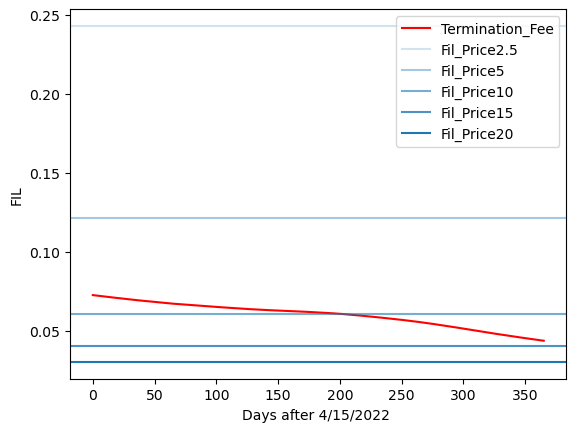

In [144]:
sns.lineplot(termination_fees, c='r', label='Termination_Fee')

alphas = [0.2,0.4,0.6,0.8,1]
for idx, price in enumerate(fil_prices): 
    plt.axhline(resale_value/price * 0.3, label='Fil_Price' + str(price),alpha=alphas[idx])
    
plt.ylabel('FIL')
plt.xlabel('Days after 4/15/2022 ')
plt.legend()

### Constants

In [37]:
# Helpful Constants 
GiB = 2**30 
TiB = 2**40
PiB = 2**50 
EiB = 2**60

# Date the Policy is Introduced 
intervention_date = pd.to_datetime('2023-04-15')
start_date = pd.to_datetime('2022-04-01')

# Current Gas Cost of Sealing a 32 GiB Sector: Source: https://www.filscout.com/us
sealing_gas = 0.0485 * GiB/TiB * 32
path = os.getcwd() + '/results/'

### Helper Functions

In [116]:
# Extract relevant Fields from mecha-FIL output
def get_scenario_df(path: str=None) -> pd.DataFrame:
    df_full = pd.read_csv(path)
    df = df_full[['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index)
    return df 

def filter_df_date(df_in, min_date, max_date):
    df_out = df_in[(df_in['date']>= pd.to_datetime(min_date)) & (df_in['date']<=pd.to_datetime(max_date))]
    return df_out

# Sector Utility Function 
# In the case of No-Termination, gas == pledge_diff == sealing_cost == 0 
def compute_sector_utility(pledge: float=1,
                           total_rewards: float=0,
                           gas:float=0,
                           sealing_cost: float=0,
                           pledge_diff:float=0, 
                           termination_fee: float=0) -> float:

    net_rewards = total_rewards - gas - sealing_cost - pledge_diff - termination_fee
    return net_rewards/pledge

def compute_termination_fee(rewards: pd.Series=pd.Series([None]),
                            termination_days: float=140) -> float: 
    return rewards.head(termination_days).sum()

def compute_utility_terminate(rewards: float=0, 
                     gas: float=sealing_gas, 
                     sealing_cost: float=3*sealing_gas, 
                     old_pledge: float=0,
                     new_pledge: float=0, 
                     termination_fee: float=0) -> float:
    
    pledge_diff = new_pledge - old_pledge 
    return (compute_sector_utility(pledge=new_pledge,
                                  total_rewards=rewards,
                                  gas=sealing_gas,
                                  sealing_cost=0, 
                                  pledge_diff=pledge_diff, 
                                  termination_fee=termination_fee))

def compute_utility_no_terminate(pledge: float=0, 
                                 rewards: float=0) -> float: 
    return (compute_sector_utility(pledge=pledge, 
                                  total_rewards=rewards, 
                                  gas=0, 
                                  sealing_cost=0,
                                  pledge_diff=0,
                                  termination_fee=0))
# For Plotting Ease
def construct_sim_paths(path=os.getcwd() + '/results/',
                        sim_scenario: str = None) -> list: 
    sim_strs = []
    for i in range(0,5):
        sim_strs.append(path + sim_scenario + '_' + str(i+1) + 'Y.csv')
    return sim_strs

def ex_ante_period(days: int=0) -> list:
    dates = [intervention_date]
    for i in range(days): 
        dates.append(dates[-1] + dt.timedelta(-1))
    return dates

### Main Logic to Compute Utility Curves 

In [9]:
# Given a cleaned output of the mecha-Fil Simulation this function computes 
# utility curves for SP's to terminate or not terminate sectors 
# on the intervention date of the SDM Policy, given a rewards time horizon 
# following the policy, an initial sector seal date, and the chosen 
# Sector Duration Multiplier of the sector. It will return a dataframe of utility curves
# for a sector sealed on each date

def compute_utility_curves(start_date: pd.Timestamp=pd.Timestamp(None), 
                           decision_date: pd.Timestamp=pd.Timestamp(None),
                           reward_years: float=0, 
                           sector_multiplier: float=None,
                           termination_days: float=90,
                           df: pd.DataFrame=pd.DataFrame(None)) -> pd.DataFrame:
    
    # Start Date for SP Utility Model
    start_date = start_date 
    
    # Initial Date First Sector is Sealed (Start Date of Utility Curves)
    seal_date = start_date 
    
    # Duration Sector Rewards Are Computed For 
    reward_years = reward_years
    # End Date (days after intervention rewards are summed for)
    end_date = decision_date + dt.timedelta(365*reward_years)
    
    # Sector QAP Multiplier 
    sector_multiplier = sector_multiplier 
    
    # Initialize Masks for DataFrame Dates 
    rewards_mask = (df.index>=decision_date) & (df.index<=end_date)
    results_mask = (df.index>=start_date) & (df.index<decision_date)
    
    # Rewards Vectors in Termination and Non_Termination Cases
    rewards_no_terminate = df[rewards_mask]['day_rewards_per_sector']
    rewards_terminate = sector_multiplier * rewards_no_terminate

    # Compute Total Rewards for Selected Sim Duration 
    total_rewards_no_terminate = rewards_no_terminate.sum()
    total_rewards_terminate = rewards_terminate.sum()
    #print(total_rewards_terminate - total_rewards_no_terminate)

    # New Pledge if SP Terminates Sector
    new_pledge = float(sector_multiplier * df[df.index==decision_date]['day_pledge_per_QAP'].values)
   # print(new_pledge)
    # Initialize Utility Curves 
    utility_no_terminate = []
    utility_no_terminate_annl = []
    utility_terminate = []
    utility_terminate_annl = []
    utility_diff = []
    utility_diff_annl = []
    
    # Calculate Termination Fee 
    termination_fee = compute_termination_fee(rewards=df[rewards_mask]['day_rewards_per_sector'],
                                              termination_days=termination_days)

    #Construct Utility Curves Starting from First Seal Date
    while (seal_date < decision_date): 
        old_pledge = float(df[df.index==seal_date]['day_pledge_per_QAP'].values)
        utility_no_terminate.append(compute_utility_no_terminate(pledge=old_pledge, 
                                                                 rewards=total_rewards_no_terminate))
        utility_no_terminate_annl.append((utility_no_terminate[-1]+1)**(1/reward_years) - 1)

        utility_terminate.append(compute_utility_terminate(rewards=total_rewards_terminate, 
                                                           gas=sealing_gas, 
                                                           sealing_cost=0, 
                                                           old_pledge=old_pledge, 
                                                           new_pledge=new_pledge, 
                                                           termination_fee=termination_fee))
        utility_terminate_annl.append((utility_terminate[-1]+1)**(1/reward_years) -1)

        utility_diff.append(utility_no_terminate[-1] - utility_terminate[-1])
        utility_diff_annl.append(utility_no_terminate_annl[-1] - utility_terminate_annl[-1])
        seal_date += dt.timedelta(1)

    results_dict = {#'ROI_No_Terminate': utility_no_terminate,
                    'ROI_No_Terminate_annl': utility_no_terminate_annl,
                    #'ROI_Terminate': utility_terminate, 
                    'ROI_Terminate_annl': utility_terminate_annl,
                    #'ROI_Difference': utility_diff,
                    'ROI_Difference_annl': utility_diff_annl}
    results_df = pd.DataFrame(results_dict, columns=results_dict.keys())
    results_df.index = df[results_mask].index
    return results_df
                           

#### Plotting Utility Curve Function 

In [10]:
# Plot and Store Results for a Given Simulation Scenario with Varying Durations
# Will also return a dict of the results

def plot_utility_scenarios(sim_scenario: str=None,
                           decision_date: pd.Timestamp=intervention_date,
                           sector_multiplier: float=0.,
                           reward_years: float=0.) -> dict:
    
    print('Terminated Sector with Multiplier '
         + str(sector_multiplier) + ' over a ' 
         + str(reward_years) + ' time horizon of rewards starting from the intervention date of the SDM Policy'
         + ' on decision date ' + str(decision_date))
    
    # Initialie Figures and Subplots
    sns.set(rc = {'figure.figsize':(10,10)})
    fig, axs = plt.subplots(5,1, sharey=True, sharex=True)
    
    if sim_scenario == '1a': 
        fig.suptitle('All Sectors: CC-Gradual')
    elif sim_scenario == '1b': 
        fig.suptitle('All Sectors: CC-Jump Extend')
    elif sim_scenario == '2a': 
        fig.suptitle('New Sectors: Gradual Onboarding')
    elif sim_scenario == '2b': 
        fig.suptitle('New Sectors: CC-Jump')
    else: 
        raise Exception('Not a valid Simulation Scenario String')

    # Get List of Strings for reading in dataframes
    sim_strs = construct_sim_paths(sim_scenario=sim_scenario)

    # Just to keep - can store all the results in a dict of DF's
    results_dict = {}
    
    # Common Y-axes label across subplits
    M = 5
    yticks = ticker.MaxNLocator(M)

    for idx, sim in enumerate(sim_strs): 
        df = get_scenario_df(sim)
        utility_curves = compute_utility_curves(start_date=start_date, 
                           decision_date=decision_date,
                           reward_years=reward_years, 
                           sector_multiplier=sector_multiplier, 
                           df=df, 
                           termination_days=90)
        if idx == 0:
            sns.lineplot(data=utility_curves, ax=axs[idx])
            plt.setp(axs[idx].get_legend().get_texts(), fontsize='2') 
            sns.move_legend(axs[idx], "upper left", bbox_to_anchor=(1, 1))
            axs[idx].set_title('Average Network Sector Duration: ' + str(idx+1) + ' Years')
            axs[idx].yaxis.set_major_locator(yticks)
        else: 
            sns.lineplot(data=utility_curves, ax=axs[idx], legend=False)
            axs[idx].set_title('Average Network Sector Duration: ' + str(idx+1) + ' Years')

        results_dict['Duration_' + str(idx+1) + '_Yrs'] = utility_curves
    
    fig.text(0.5, 0.04, 'Initial Sector Seal Date', ha='center')
    fig.text(0.01, 0.5, 'SP ROI', va='center', rotation='vertical')
    
    return results_dict

### Termination Incentives in Decision Date Window

In [11]:
## Look at Utilities for a Time Window Following The Intervention Date of the SDM 

def compute_utilities_in_window(window: int=365, 
                                reward_years: float=3., 
                                sector_multiplier: float=3., 
                                sim_path: str=None) -> dict: 
                                
    decision_dates = ex_ante_period(days=window)
    utility_dfs = {}
    df = get_scenario_df(path=sim_path)
    for idx, date in enumerate(decision_dates): 
        utility_df = compute_utility_curves(start_date=start_date, 
                                            decision_date=date, 
                                            reward_years=reward_years, 
                                            sector_multiplier=sector_multiplier,
                                            df=df)
        utility_dfs[date] = utility_df
        
    return utility_dfs

In [13]:
## Plot Utilities for Tme Window
def plot_ROI_Diff_window(utility_dfs: dict={},
                         sim_scenario: str=None) -> None: 
    
    sns.set(rc = {'figure.figsize':(10,5)})
    color = (sns.dark_palette("blue"))
    shades = np.linspace(0.2,1,len(utility_dfs))
    
    for idx, decision_date in enumerate(utility_dfs.keys()): 
        if idx == 0: 
            sns.lineplot(data=utility_dfs[decision_date]['ROI_Difference_annl'], 
                 color='b',
                 alpha=shades[idx], 
                 label=decision_date)
        elif idx == len(utility_dfs)-1:
            sns.lineplot(data=utility_dfs[decision_date]['ROI_Difference_annl'], 
                 color='b',
                 alpha=shades[idx], 
                 label=decision_date)
        else: 
            sns.lineplot(data=utility_dfs[decision_date]['ROI_Difference_annl'], 
                 color='b',
                 alpha=shades[idx])
            
    if sim_scenario == '1a': 
        plt.title('All Sectors: CC-Gradual')
    elif sim_scenario == '1b': 
        plt.title('All Sectors: CC-Jump Extend')
    elif sim_scenario == '2a': 
        plt.title('New Sectors: Gradual Onboarding')
    elif sim_scenario == '2b': 
        plt.title('New Sectors: CC-Jump')


### Constructing Heatmaps

In [14]:
def plot_heatmap(df_heatmap: pd.DataFrame(None),
                 sim_scenario: str=None) -> None: 
    
    results_plotting = df_heatmap.copy(deep=True)
    results_plotting.index = results_plotting.index.strftime('%Y/%m/%d')
    
    # Take Transpose for Heatmap
    results_plotting = results_plotting.T
    
    norm = TwoSlopeNorm(vcenter=0)
    
    # Init Seaborn heatmap
    heatmap = sns.heatmap(data=results_plotting, 
                          cmap="RdYlGn", 
                          norm=norm, 
                          cbar_kws={'label': 'Difference in SP ROI (annl.) \n Termination vs Non Termination'})

    #if sim_scenario == '1a': 
    #    plt.title('All Sectors: CC-Gradual')
    #elif sim_scenario == '1b': 
    #    plt.title('All Sectors: CC-Jump Extend')
    #elif sim_scenario == '2a': 
     #   plt.title('New Sectors: Gradual Onboarding')
    #elif sim_scenario == '2b': 
     #   plt.title('New Sectors: CC-Jump')

    plt.ylabel('SDM of Terminated and Reonboarded Sector')
    plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
    heatmap.set_xticklabels(labels=heatmap.get_xticklabels(), rotation=45, fontsize=14)
    
    for ind, label in enumerate(heatmap.get_xticklabels()):
        if ind % 5 == 0:  # every 5th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    

In [42]:
def compute_heatmap(window: int=365, 
                    reward_years: float=3.,
                    df: pd.DataFrame=None) -> dict:
    
    # Init list of Dates for which SP Can choose to terminate/reonboard or extend
    decision_dates = ex_ante_period(days=window)
    
    # Init List of Sector Multipliers SP can get upon reonboard
    sector_multipliers = [1,2,3,4,5]
  
    # Get df of macro simulation
    df = df
    
    #Initialize DF Which Stores Results 
    results_heatmap = pd.DataFrame()
    
    # Populate heatmap with average utility for each decision date run 
    for sector_multiplier in sector_multipliers:
        avg_utility_diff = {}
        for idx, date in enumerate(decision_dates): 
            utility_df = compute_utility_curves(start_date=start_date, 
                                                decision_date=date, 
                                                reward_years=reward_years, 
                                                sector_multiplier=sector_multiplier,
                                                df=df)
            avg_utility_diff[date] = utility_df['ROI_Difference_annl'].mean()

        results_heatmap[str(sector_multiplier)] = pd.Series(avg_utility_diff)   
    
    return results_heatmap

# SDM v2 Scenario Analysis

In [4]:
fp_sims = "/Users/vkalghatgi/Dropbox/Mac/Desktop/duration_loop_results_Feb15_2023.pkl"
#fp_sims = os.path.join(offline_folder, 'duration_loop_results_Feb15_2023.pkl')
with open(fp_sims, 'rb') as f:
    duration_loop_results = pickle.load(f)

In [23]:
target_locks=[0.1,0.2,0.3,0.4,0.5]
onboardings=[3,5,10,15]
years=[1,3,5]
burn_boosts=[1,2,3]

colormap_vecs = ['Purples', 'Greens', 'Oranges']
cmap_access_vec = np.linspace(0.4,0.9,len(years))
MEGA = 1_000_000

Terminate, Sell 50% 

## 2a

In [63]:
target_lock_i=0.1
regime='data_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
    heatmap.set_xticklabels(labels=heatmap.get_xticklabels(), rotation=45, fontsize=14)
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

IndentationError: unexpected indent (870981447.py, line 16)

In [ ]:
target_lock_i=0.2
regime='data_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [ ]:
target_lock_i=0.3
regime='data_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [ ]:
target_lock_i=0.4
regime='data_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

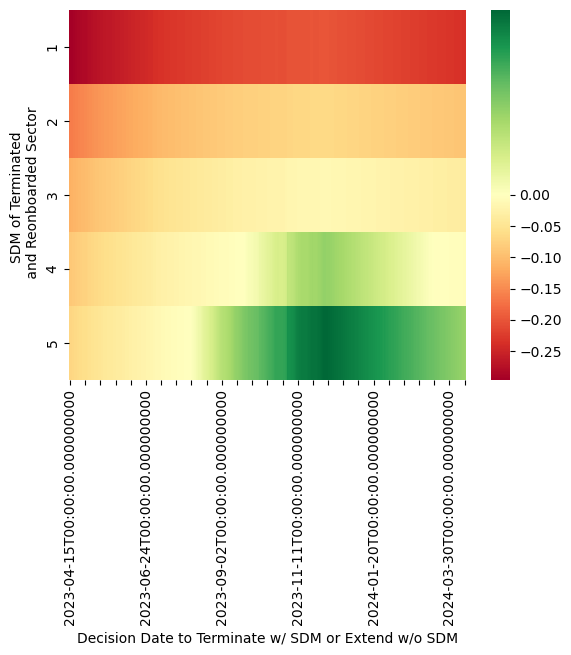

In [57]:
target_lock_i=0.5
regime='data_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [ ]:
regime='data_conserved'

#min_time = dt.date(2023,1,1)
#max_time = dt.date(2026,3,1)

yr=3
fig, axes = plt.subplots(nrows=len(target_locks), 
                         ncols=len(onboardings), 
                         figsize=(21,15), 
                         sharex=True, 
                         sharey=True)
for bi, burn_boost in enumerate(burn_boosts):
    cmap = cm.get_cmap(colormap_vecs[bi])
    for ti, target_lock_i in enumerate(target_locks):
        for oi, onboarding_i in enumerate(onboardings):
            ax = axes[ti,oi]
                #c = cmap(cmap_access_vec[yi])
            key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
            df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
            df = df.set_index('date')
            df.index = pd.to_datetime(df.index)
            results = compute_heatmap(df=df)
            print('hi')
            norm = TwoSlopeNorm(vcenter=0)
            heatmap = sns.heatmap(data=results, 
                  cmap="RdYlGn", 
                  norm=norm, 
                  ax=ax)
               # plt_df = filter_df_date(plt_df, min_time, max_time)
                #plt_df['cum_outflow'] = plt_df['network_gas_burn'] + plt_df['network_locked']
                #plt_df['cum_inflow'] = plt_df['total_vest'] + plt_df['cum_network_reward']
                #plt_df['cum_netflow'] = plt_df['cum_inflow'] - plt_df['cum_outflow']
                #plt_df['netflow'] = plt_df['cum_netflow'].diff()
                #ax.plot(plt_df['date'], plt_df['cum_netflow']/MEGA, label=f'{yr}y + {burn_boost}x burn', color=c, lw=2)
                
            #ax.axhline(800, linestyle=':', color='k')
            #ax.axhline(700, linestyle=':', color='k')
            #ax.axhline(600, linestyle=':', color='k')
            #ax.axhline(500, linestyle=':', color='k')
            #ax.axhline(400, linestyle=':', color='k')
            #ax.axhline(300, linestyle=':', color='k')
            ax.set_title(f'TL={target_lock_i}, {onboarding_i}PiB/day')
            ax.tick_params(axis='x', labelrotation=40)
            ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
            ax.set_ylabel("SDM")
            #ax.set_ylim(200,800)
#ax.legend();
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.suptitle('SDM // Data Conservation Regime // Circulating Supply')
plt.tight_layout()
#plt.savefig(os.path.join(results_folder, f'1b_cs_{regime}.png'))

## 2b

In [ ]:
target_lock_i=0.1
regime='fil_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [ ]:
target_lock_i=0.2
regime='fil_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [ ]:
target_lock_i=0.3
regime='fil_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [ ]:
target_lock_i=0.4
regime='fil_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

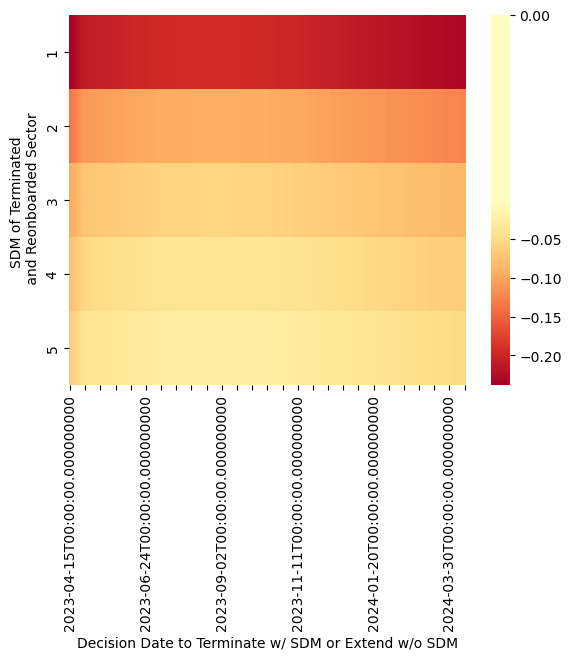

In [62]:
target_lock_i=0.5
regime='fil_conserved'
burn_boost = 1
onboarding_i = 5
key = f'Scenario-2_TargetRBP={onboarding_i}({yr}-Y_{target_lock_i}-LT_{burn_boost}-bb-{regime}-regime)'
df = duration_loop_results[key]['rbp_roi'][['date', 'day_pledge_per_QAP', 'day_rewards_per_sector']]
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
results = compute_heatmap(df=df).T
norm = TwoSlopeNorm(vcenter=0)
heatmap = sns.heatmap(data=results, 
      cmap="RdYlGn", 
      norm=norm)
plt.ylabel('SDM of Terminated \n and Reonboarded Sector')
plt.xlabel('Decision Date to Terminate w/ SDM or Extend w/o SDM')
for ind, label in enumerate(heatmap.get_xticklabels()):
    if ind % 5 == 0:  # every 5th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

## 1a. Net Daily Flow 

# Former Termination Analysis (Old)

## Scenario Analysis 

### 1A - All Sector CC-gradual
- Smooth: CC extensions gain SDM at at scheduled extension time, which is duration d = 365 after onboarding for the first time, and 3*365 after 

#### Termination Incentives on Date of SDM Introduction

Terminated Sector with Multiplier 1.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


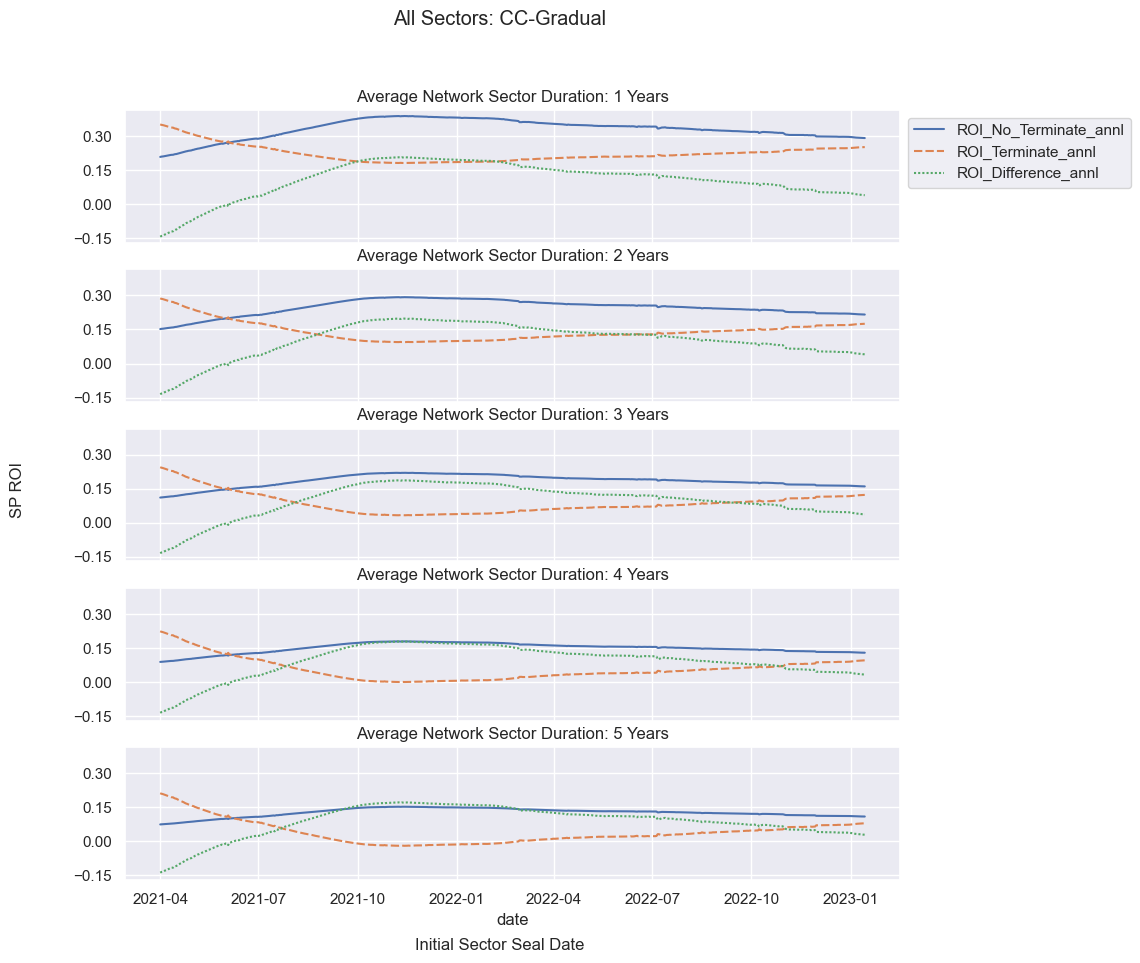

In [10]:
# Decision Date is the Date of the Policy's intervention
plot_utility_scenarios(sim_scenario='1a', 
                           sector_multiplier=1.,
                           reward_years=3.);

Terminated Sector with Multiplier 3.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


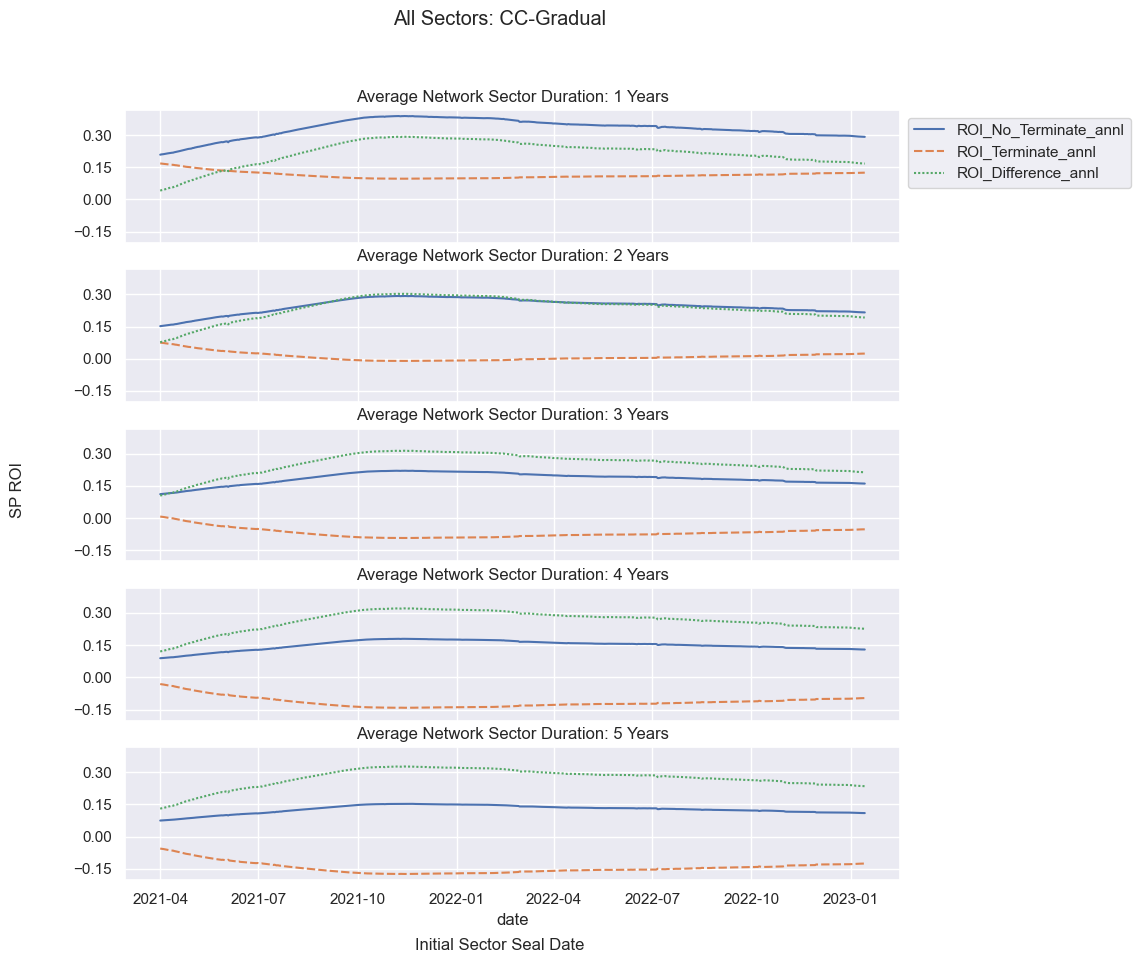

In [11]:
# Decision Date is the Date of the Policy's intervention
plot_utility_scenarios(sim_scenario='1a', 
                           sector_multiplier=3.,
                           reward_years=3.);

#### Ex-Ante Expectations for Termination Incentives Following SDM Policy's Introduction

In [12]:
## Central Scenario. Macro Model - 1a-3Y, Micro Scenario is 3x Sector vs 1x Sector
ex_ante_dfs_central_1a = compute_utilities_in_window(window=365, 
                                         reward_years=3, 
                                         sector_multiplier=3, 
                                         sim_path=path+'1a_3Y.csv')

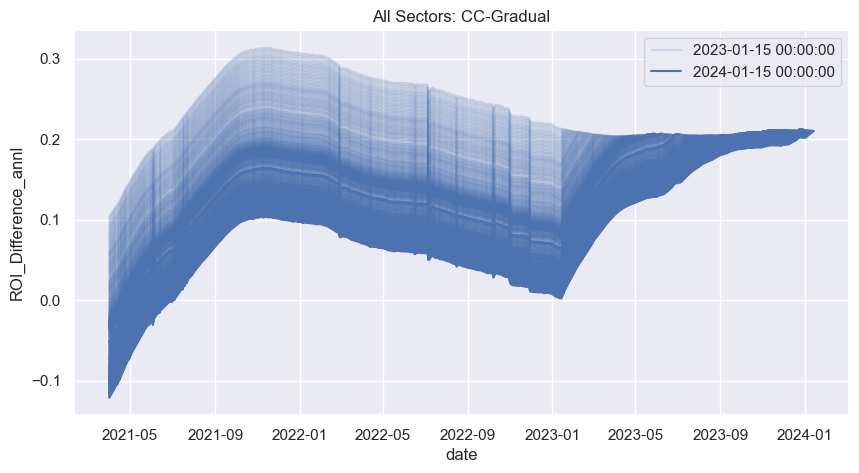

In [13]:
plot_ROI_Diff_window(utility_dfs=ex_ante_dfs_central_1a, 
                     sim_scenario='1a')

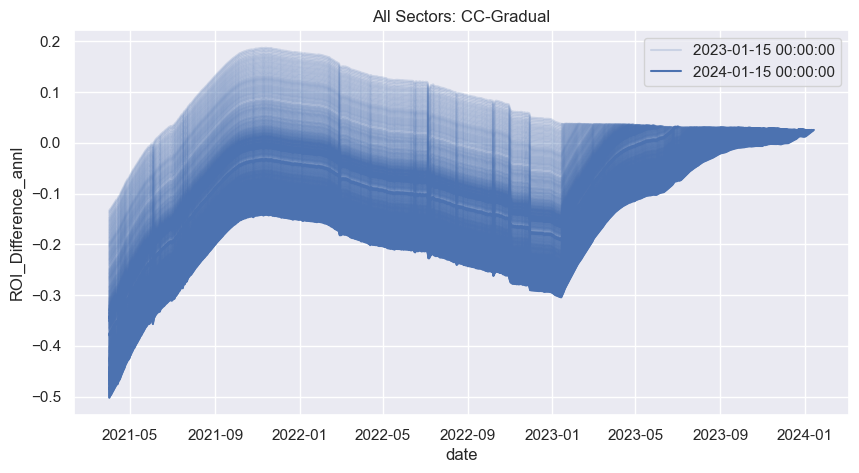

In [14]:
## Central Scenario. Macro Model - 1a-3Y, Micro Scenario is 3x Sector vs 1x Sector
ex_ante_dfs_central_1a = compute_utilities_in_window(window=365, 
                                         reward_years=3, 
                                         sector_multiplier=1, 
                                         sim_path=path+'1a_3Y.csv')
plot_ROI_Diff_window(utility_dfs=ex_ante_dfs_central_1a, 
                     sim_scenario='1a')

#### Heatmap

In [40]:
## Central Scenario. Macro Model - 1a-3Y
df_heatmap_1a = compute_heatmap(window=365, 
                                reward_years=1, 
                                sim_path=path+'1a_3Y.csv')

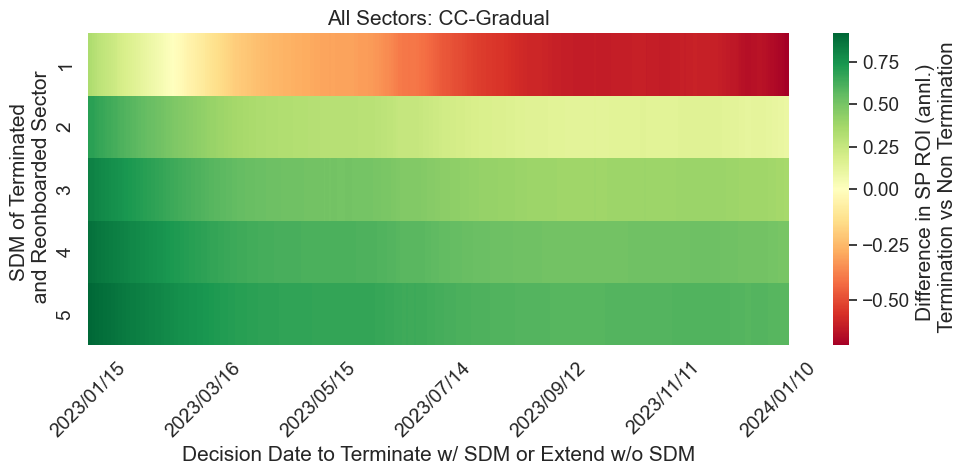

In [49]:
sns.set(font_scale=1.25)
plot_heatmap(df_heatmap=df_heatmap_1a, 
             sim_scenario='1a')
plt.tight_layout()
plt.savefig(os.path.join('results', 'heatmap_1a.png'))

### 1b 
- Shock: CC extends early to gain SDM. A significant fraction of CC power extends at the upgrade date rather than the sector expiration date. This causes a sharp jump in QAP that may cause a supply/ROI shock.

#### Termination Incentives on Date of SDM Introduction

Terminated Sector with Multiplier 1.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


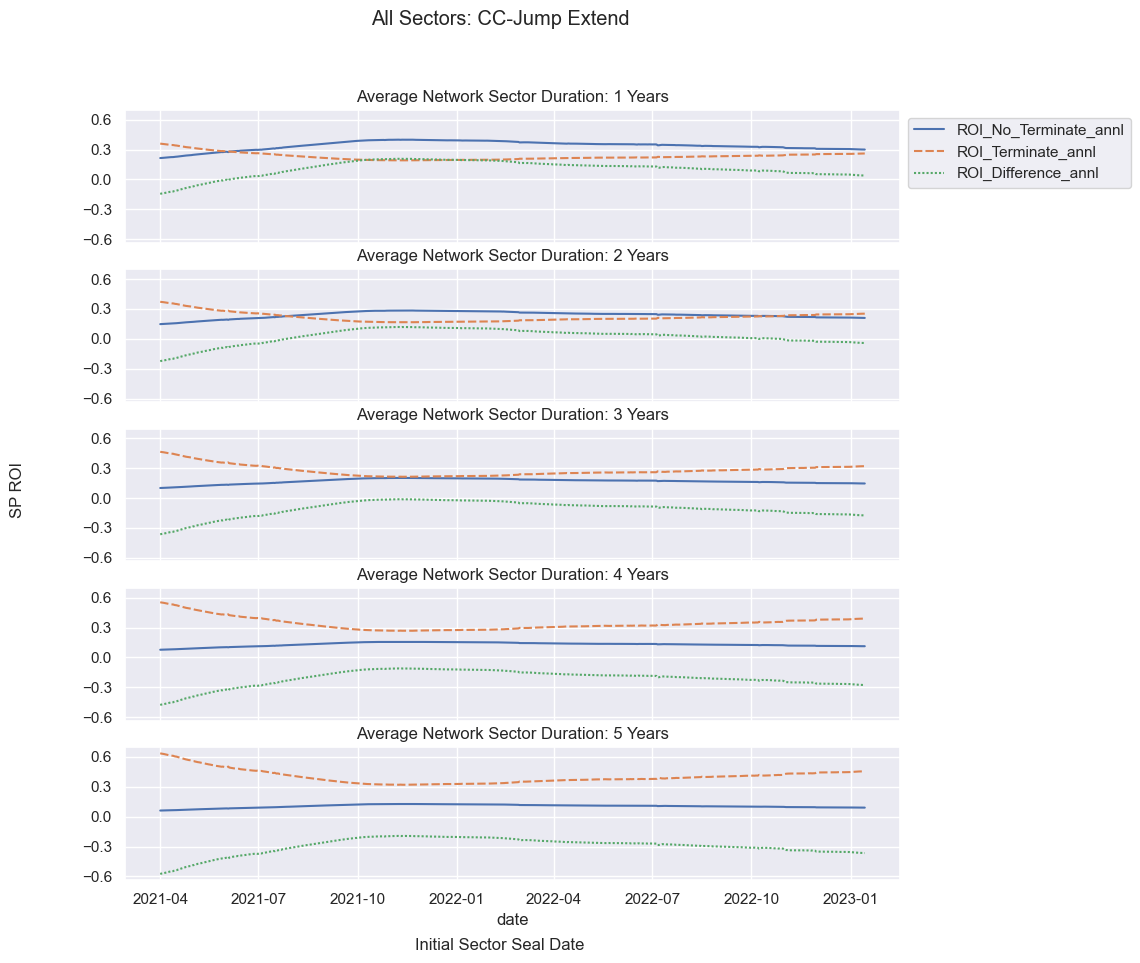

In [17]:
plot_utility_scenarios(sim_scenario='1b', 
                           sector_multiplier=1.,
                           reward_years=3.);

Terminated Sector with Multiplier 3.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


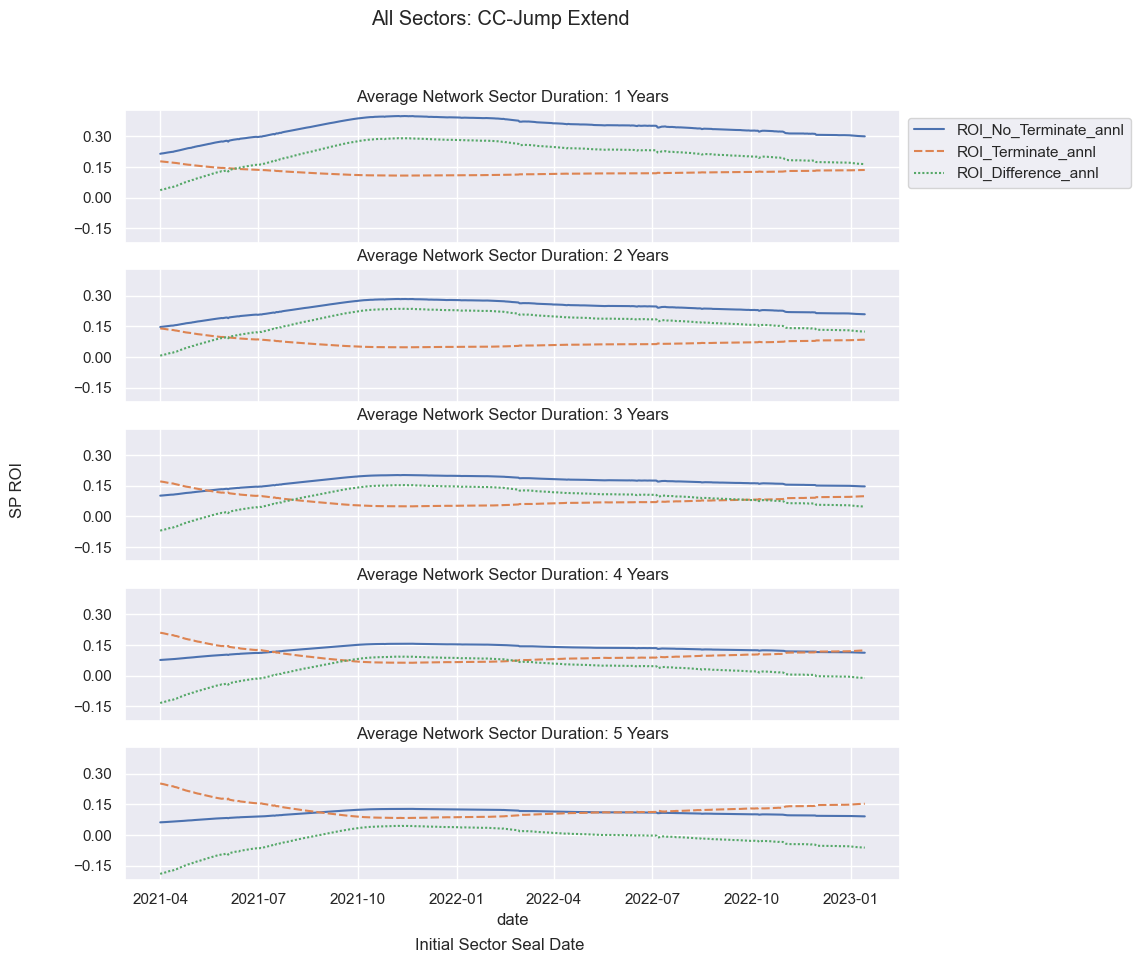

In [18]:
plot_utility_scenarios(sim_scenario='1b', 
                           sector_multiplier=3.,
                           reward_years=3.);

#### Ex-Ante Expectations for Termination Incentives Following SDM Policy's Introduction

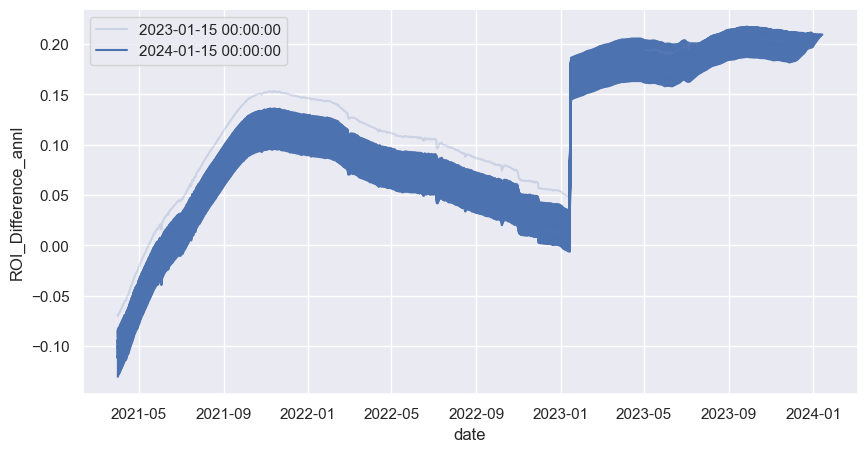

In [19]:
## Central Scenario. Macro Model - 1a-3Y, Micro Scenario is 3x Sector vs 1x Sector
ex_ante_dfs_central_1b = compute_utilities_in_window(window=365, 
                                         reward_years=3, 
                                         sector_multiplier=3, 
                                         sim_path=path+'1b_3Y.csv')
plot_ROI_Diff_window(utility_dfs=ex_ante_dfs_central_1b)

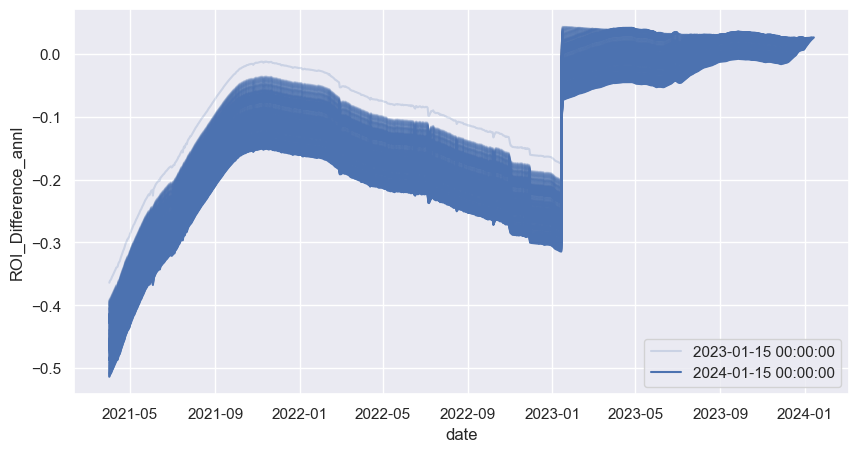

In [20]:
## Central Scenario. Macro Model - 1a-3Y, Micro Scenario is 3x Sector vs 1x Sector
ex_ante_dfs_central_1b = compute_utilities_in_window(window=365, 
                                         reward_years=3, 
                                         sector_multiplier=1, 
                                         sim_path=path+'1b_3Y.csv')
plot_ROI_Diff_window(utility_dfs=ex_ante_dfs_central_1b)

#### Heatmap

In [21]:
## Central Scenario. Macro Model - 2a-3Y
df_heatmap_1b = compute_heatmap(window=365, 
                                reward_years=3, 
                                sim_path=path+'1b_3Y.csv')

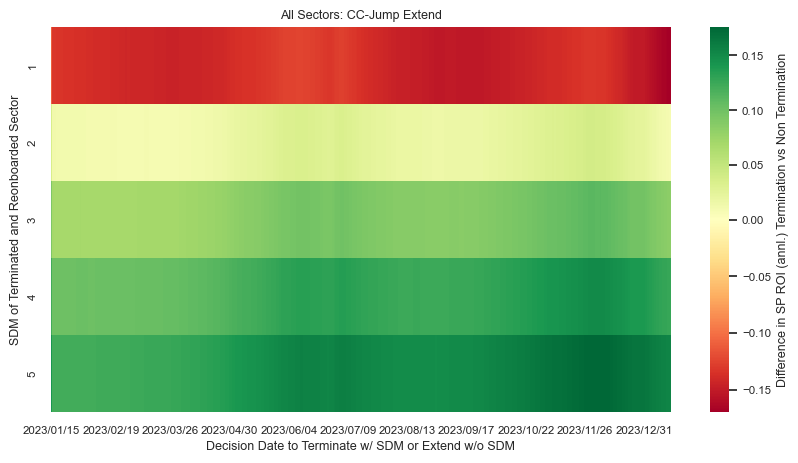

In [22]:
sns.set(font_scale=0.75)
plot_heatmap(df_heatmap=df_heatmap_1b, 
             sim_scenario='1b')

### 2A 
- Smooth: Only newly onboarded CC and deal power get SDM. Current deal/onboarding power extends/expires naturally (after 365d).

#### Termination Incentives on Date of SDM Introduction

Terminated Sector with Multiplier 3.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


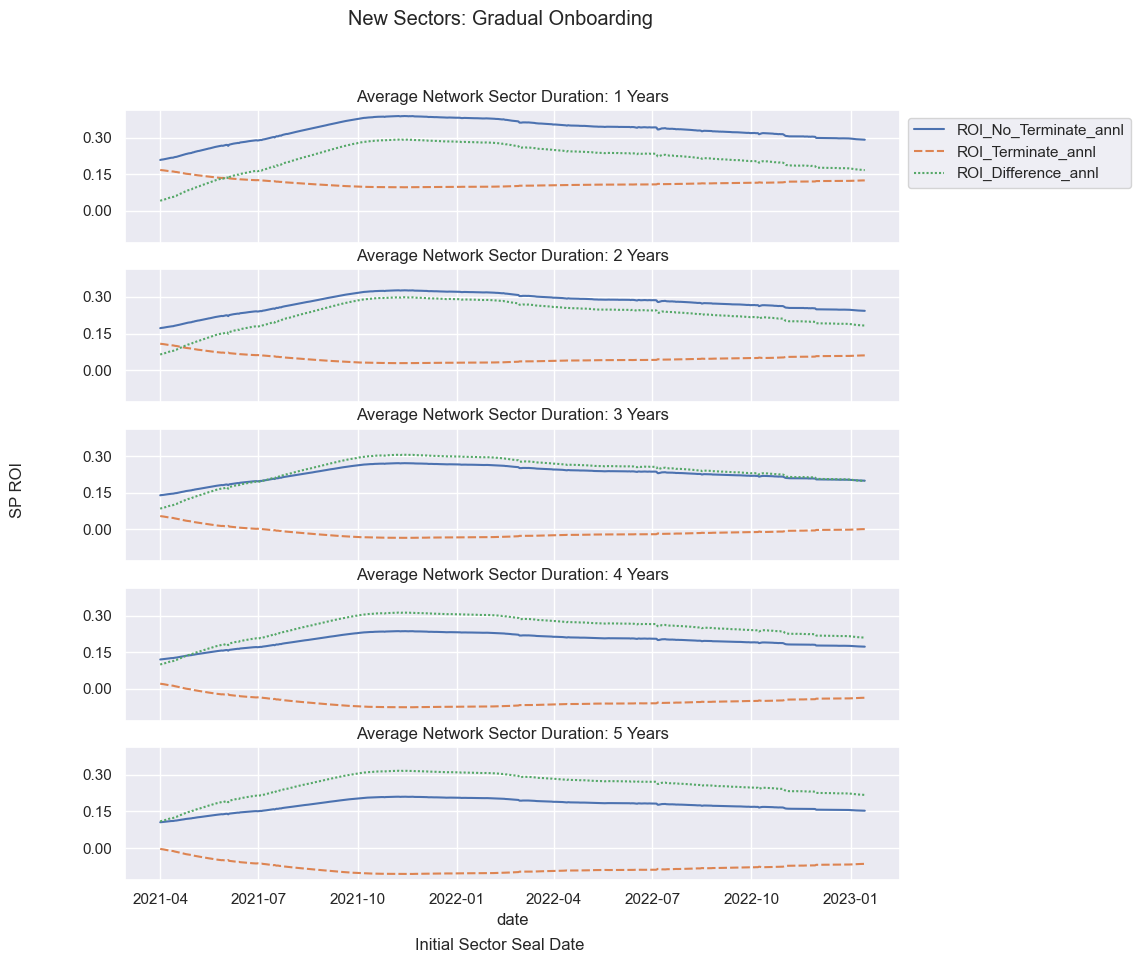

In [23]:
plot_utility_scenarios(sim_scenario='2a', 
                           sector_multiplier=3.,
                           reward_years=3.);

#### Ex-Ante Expectations for Termination Incentives Following SDM Policy's Introduction

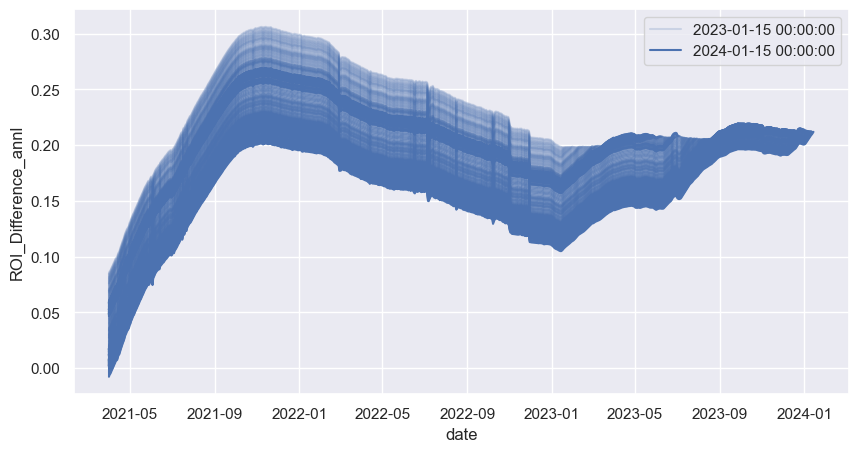

In [24]:
## Central Scenario. Macro Model - 1a-3Y, Micro Scenario is 3x Sector vs 1x Sector
ex_ante_dfs_central_2a = compute_utilities_in_window(window=365, 
                                         reward_years=3, 
                                         sector_multiplier=3, 
                                         sim_path=path+'2a_3Y.csv')
plot_ROI_Diff_window(utility_dfs=ex_ante_dfs_central_2a)

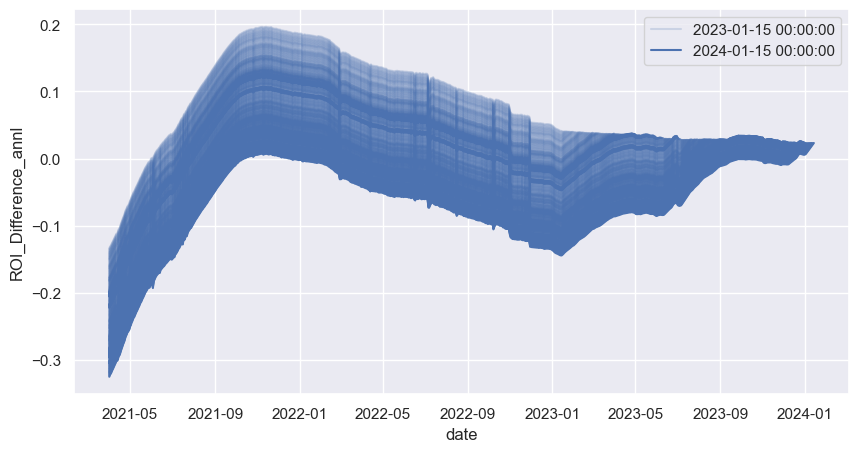

In [25]:
ex_ante_dfs_central_2a = compute_utilities_in_window(window=365, 
                                         reward_years=3, 
                                         sector_multiplier=1, 
                                         sim_path=path+'2a_3Y.csv')
plot_ROI_Diff_window(utility_dfs=ex_ante_dfs_central_2a)

#### Heatmap

In [26]:
## Central Scenario. Macro Model - 2a-3Y
df_heatmap_2a = compute_heatmap(window=365, 
                                reward_years=3, 
                                sim_path=path+'2a_3Y.csv')

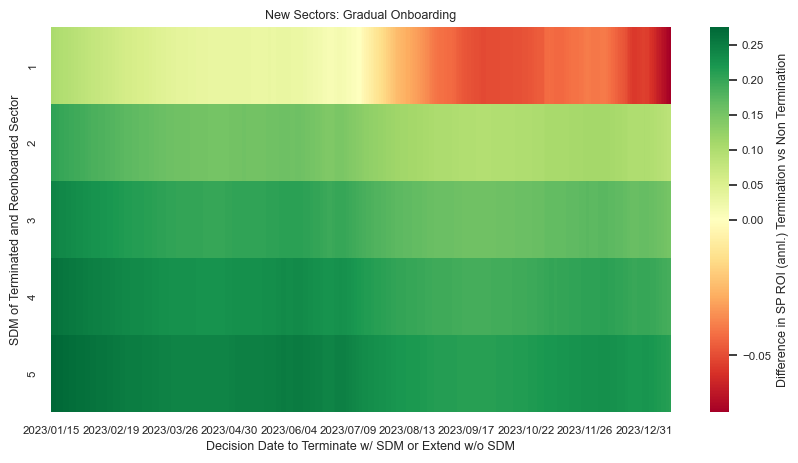

In [27]:
sns.set(font_scale=0.75)
plot_heatmap(df_heatmap=df_heatmap_2a, 
             sim_scenario='2a')

### 2B 
- CC terminates and reonboards with an SDM

#### Termination Incentives on Date of SDM Introduction

Terminated Sector with Multiplier 3.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


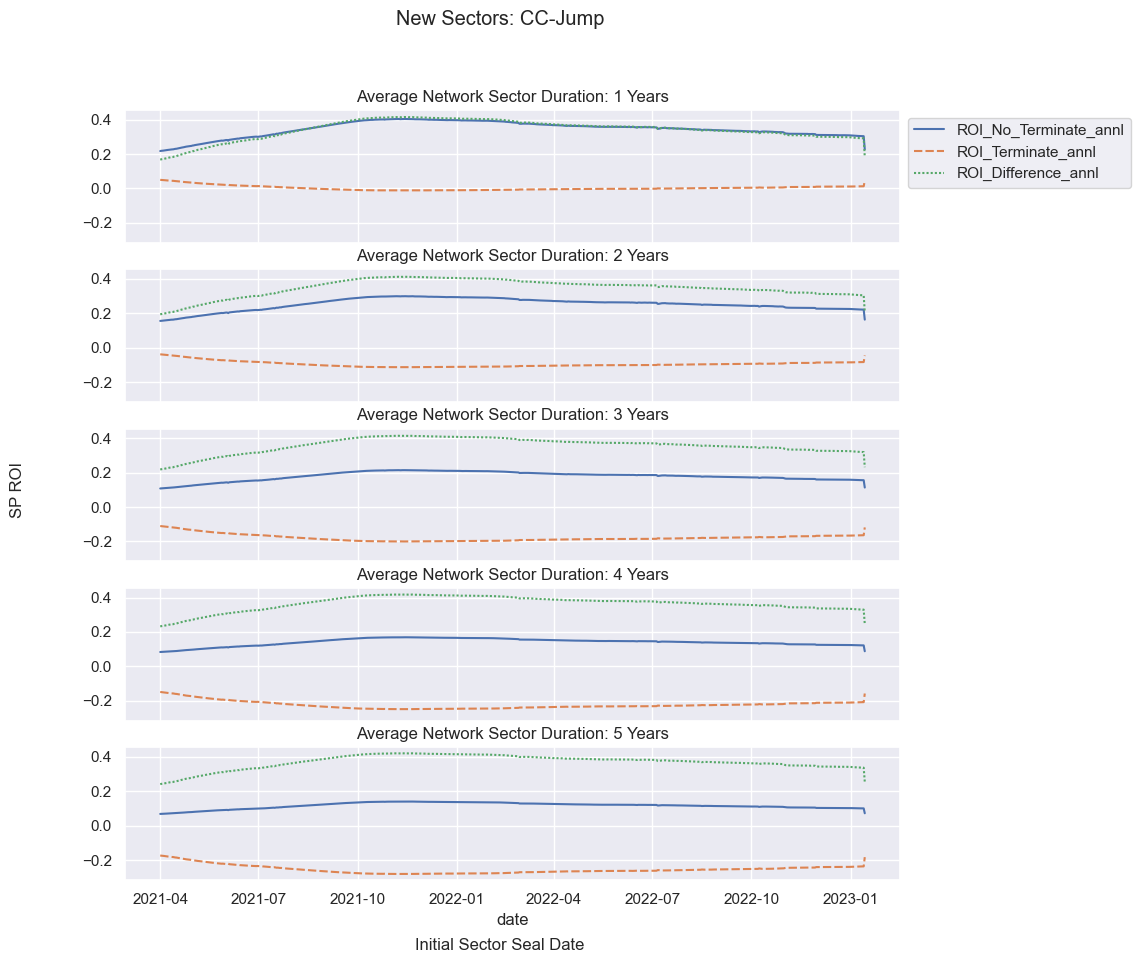

In [28]:
plot_utility_scenarios(sim_scenario='2b', 
                           sector_multiplier=3.,
                           reward_years=3.);

Terminated Sector with Multiplier 1.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


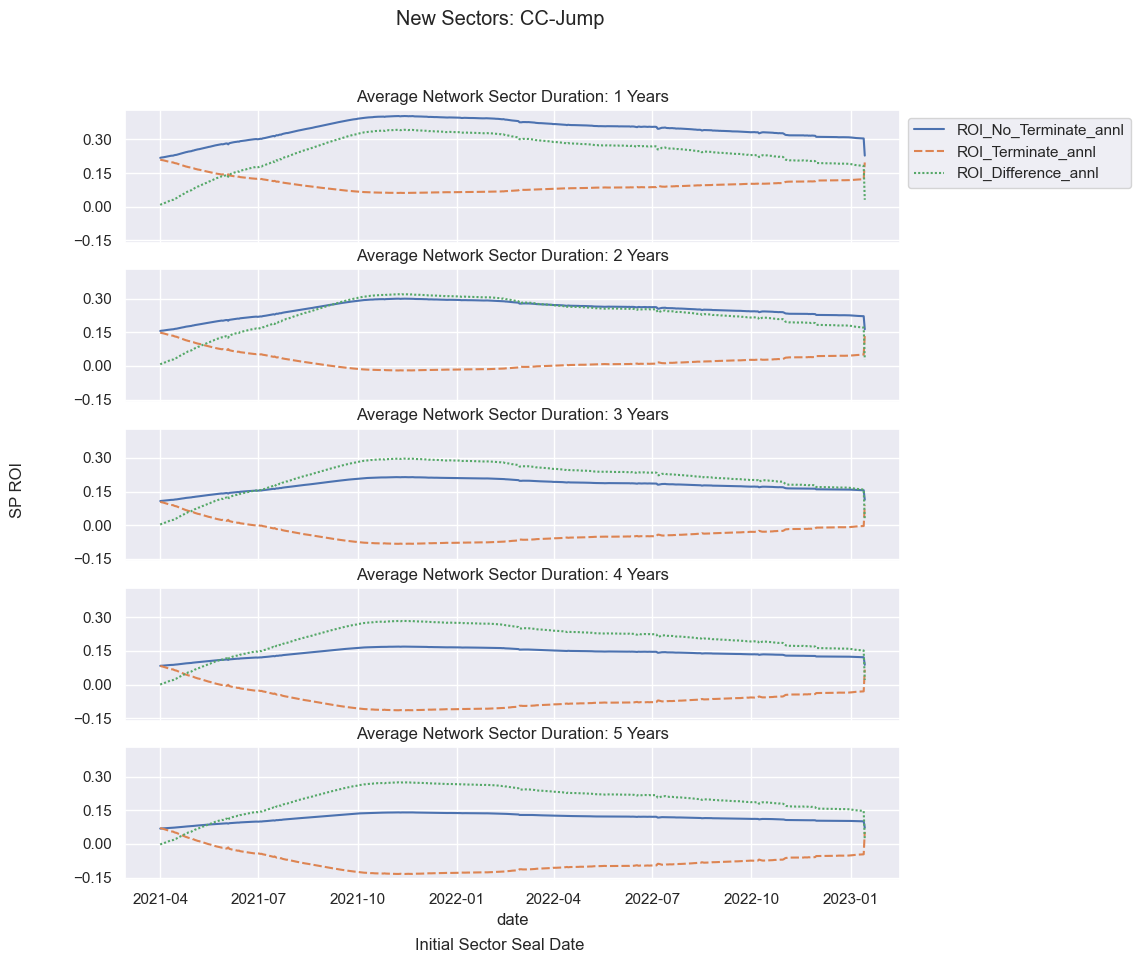

In [29]:
plot_utility_scenarios(sim_scenario='2b', 
                           sector_multiplier=1.,
                           reward_years=3.);

Terminated Sector with Multiplier 3.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


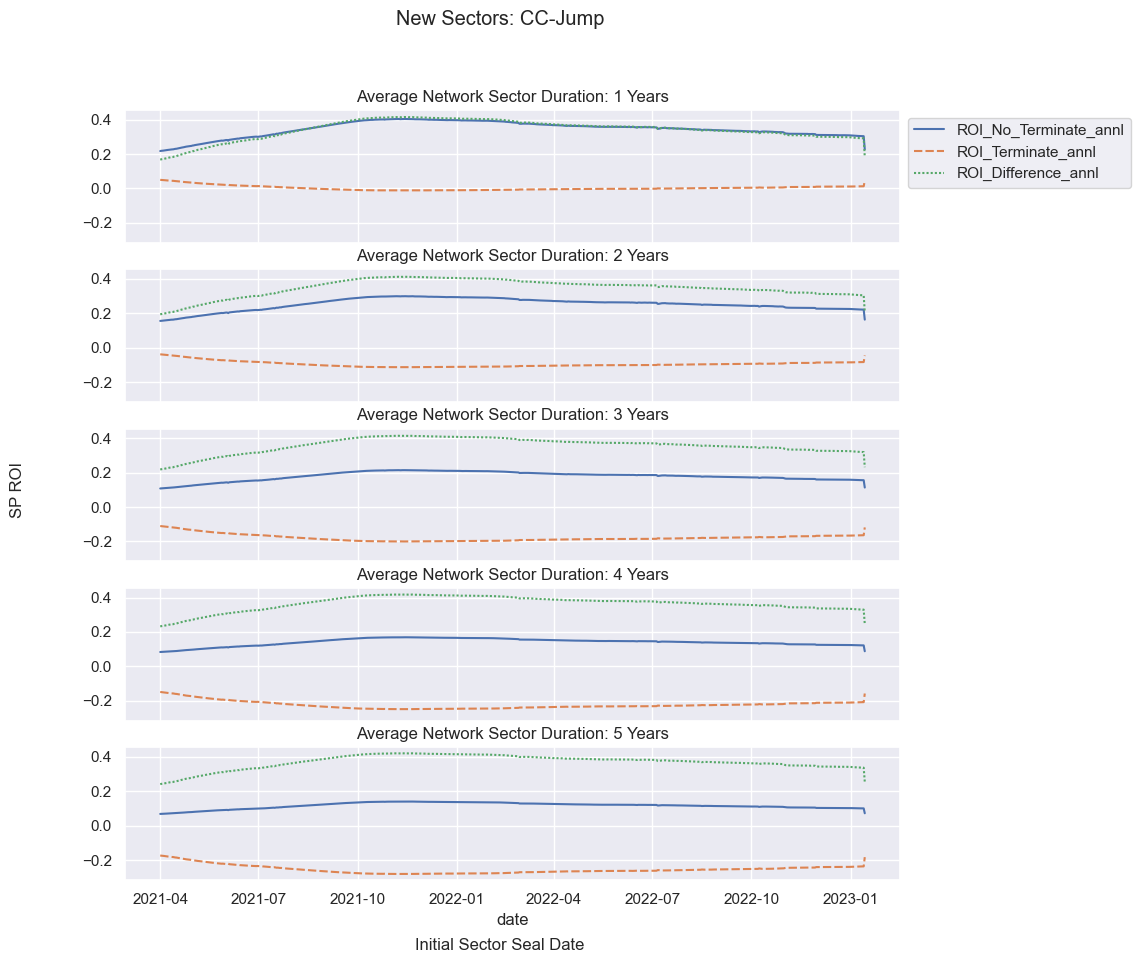

In [30]:
plot_utility_scenarios(sim_scenario='2b', 
                           sector_multiplier=3.,
                           reward_years=3.);

Terminated Sector with Multiplier 1.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


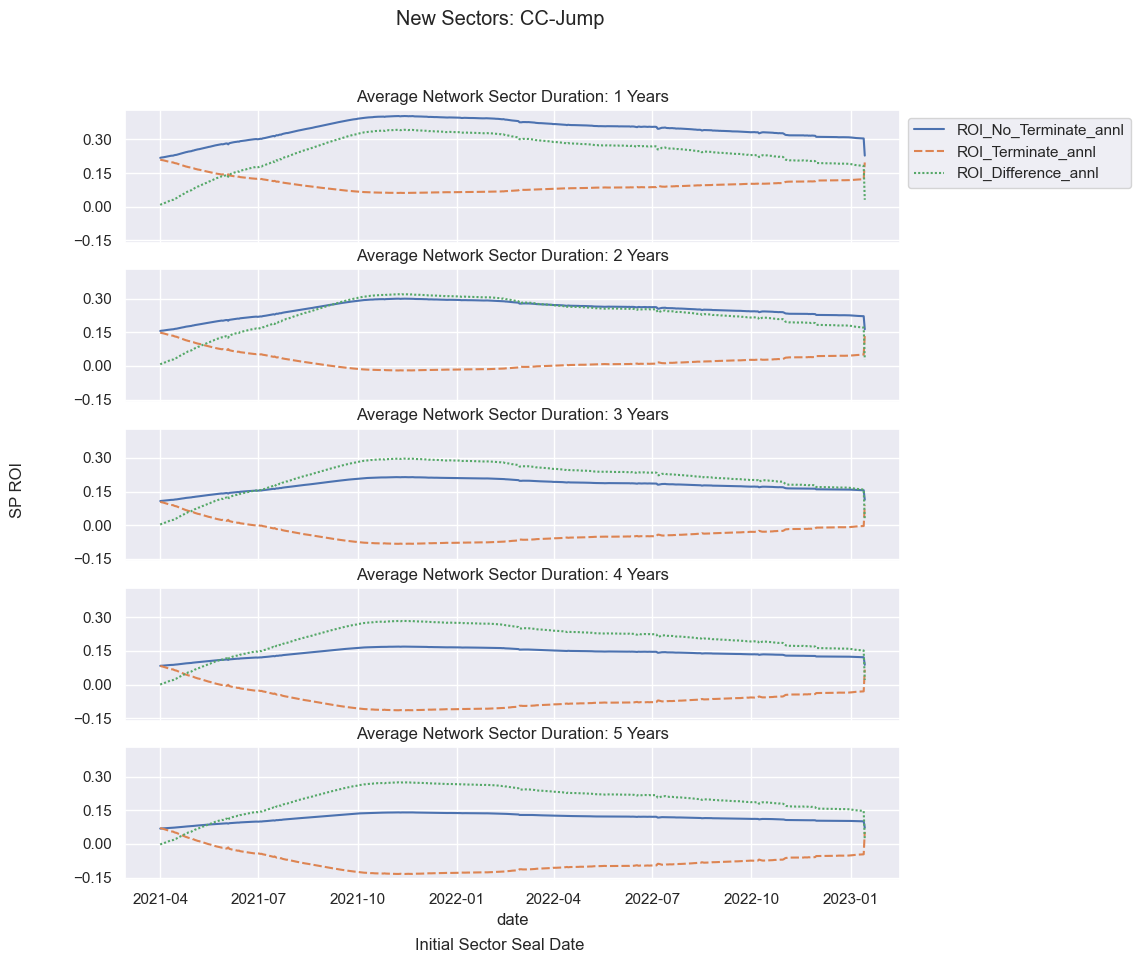

In [31]:
plot_utility_scenarios(sim_scenario='2b', 
                           sector_multiplier=1.,
                           reward_years=3.);

Terminated Sector with Multiplier 5.0 over a 3.0 time horizon of rewards starting from the intervention date of the SDM Policy on decision date 2023-01-15 00:00:00


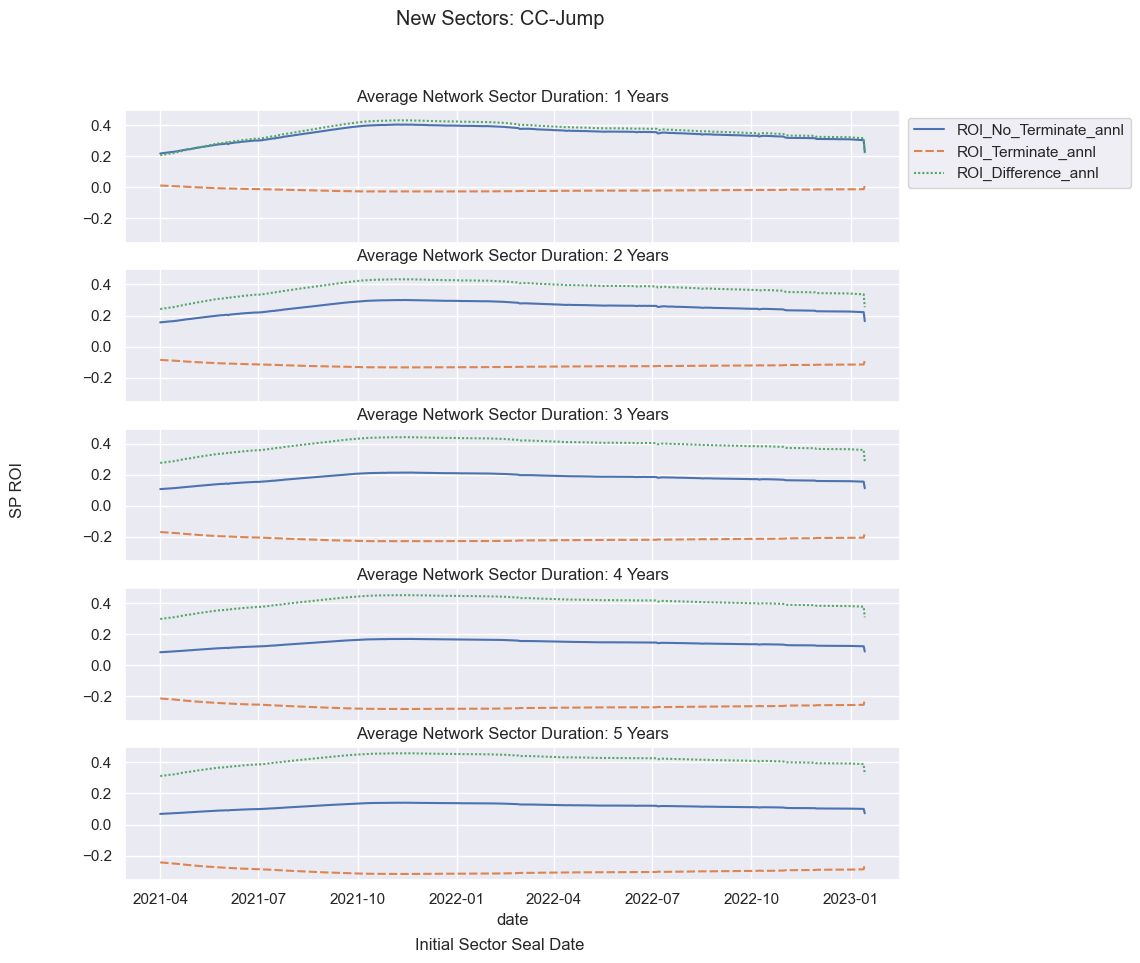

In [32]:
plot_utility_scenarios(sim_scenario='2b', 
                           sector_multiplier=5.,
                           reward_years=3.);

#### Ex-Ante Expectations for Termination Incentives Following SDM Policy's Introduction

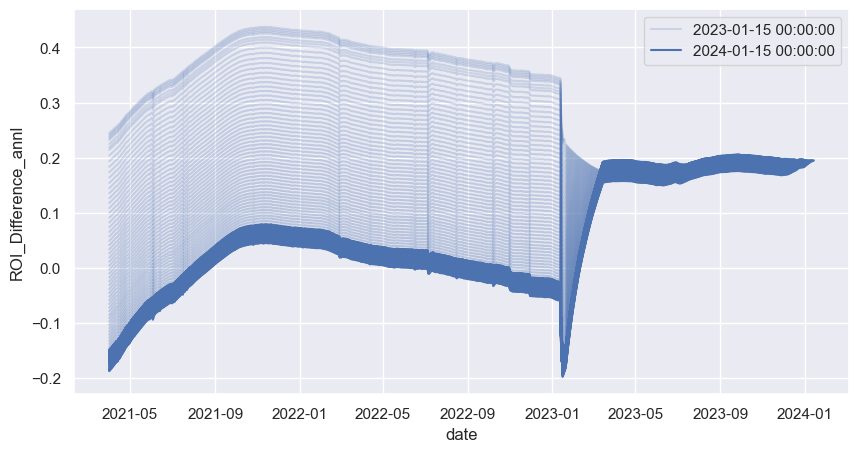

In [33]:
## Central Scenario. Macro Model - 1a-3Y, Micro Scenario is 3x Sector vs 1x Sector
ex_ante_dfs_central_2b = compute_utilities_in_window(window=365, 
                                         reward_years=3, 
                                         sector_multiplier=3, 
                                         sim_path=path+'2b_3Y.csv')
plot_ROI_Diff_window(utility_dfs=ex_ante_dfs_central_2b)

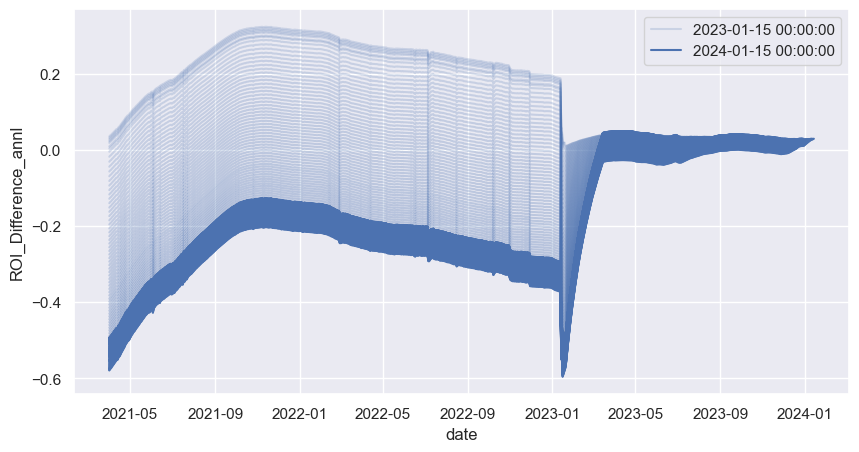

In [34]:
ex_ante_dfs_central_2b = compute_utilities_in_window(window=365, 
                                         reward_years=3, 
                                         sector_multiplier=1, 
                                         sim_path=path+'2b_3Y.csv')
plot_ROI_Diff_window(utility_dfs=ex_ante_dfs_central_2b)

#### Heatmap

In [35]:
## Central Scenario. Macro Model - 2a-3Y
df_heatmap_2b = compute_heatmap(window=365, 
                                reward_years=3, 
                                sim_path=path+'2b_3Y.csv')

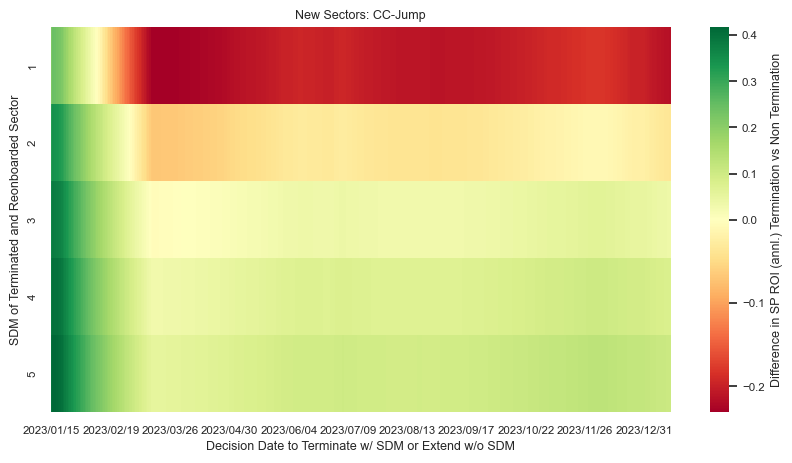

In [36]:
sns.set(font_scale=0.75)
plot_heatmap(df_heatmap=df_heatmap_2b, 
             sim_scenario='2b')